## Comparison of RandomForest and InfiniteBoost

Three classification datasets are used in experiments: [UCI covertype](https://archive.ics.uci.edu/ml/datasets/covertype), [real-sim](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html) and [citeseer](http://komarix.org/ac/ds/).

Note: 
- In these tests InfiniteBoost use the same trees as RandomForest (default in scikit-learn)
- Separate minimalistic implementation of InfiniteBoost was done specially for these tests, it uses sklearn trees (and thus can work with sparse data and deep trees).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy
import joblib
import pandas
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_covtype, load_svmlight_file
from sklearn.base import clone

## Loading datasets

In [2]:
datasets = OrderedDict()

In [3]:
# covertype  dataset
data = fetch_covtype()
X = data['data']
y = (data['target'] == 2) * 1 # majority class as a target
datasets['covtype'] = X, y

No handlers could be found for logger "root"


In [4]:
# real-sim dataset
X, y = load_svmlight_file('../../datasets/real-sim.txt' )
y = (y > 0) * 1 # converting {-1, +1} to {0, 1}
datasets['real-sim'] = X, y

In [5]:
# citeseer dataset
X, y = load_svmlight_file('../../datasets/J_Lee.txt' )
datasets['citeseer'] = X, y.astype(int)

In [6]:
for name, (X, y) in datasets.items():
    print name, 'shape: ', X.shape, 'with ', sum(y), 'positive', sum(1 - y), 'negative'

covtype shape:  (581012, 54) with  283301 positive 297711 negative
real-sim shape:  (72309, 20958) with  22238 positive 50071 negative
citeseer shape:  (181395, 105354) with  299 positive 181096 negative


## Training 

In [7]:
numpy.random.seed(42)

In [8]:
from SparseInfiniteBoosting import InfiniteBoosting

Prepare random forest and InfiniteBoost models

In [9]:
models = OrderedDict()
cross_val_qualities = OrderedDict()

models['rf'] = RandomForestClassifier(n_estimators=100, random_state=42)
for capacity in [1., 2., 4.]:
    models[str(capacity)] = InfiniteBoosting(n_estimators=100, capacity=capacity)

4-folding on all prepared datasets

In [10]:
for dataset_name, (X, y) in datasets.items():
    for name, model in models.items():
        print name
        folder = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
        cross_val_qualities[dataset_name, name] = []
        for train_indices, test_indices in folder.split(X, y):
            X_train = X[train_indices]
            X_test = X[test_indices]
            y_train = y[train_indices]
            y_test = y[test_indices]
            clf = clone(model)
            if len(y) > 500000:
                # to avoid out-of-memory errors
                clf.set_params(max_leaf_nodes=2 ** 15)
            %time clf.fit(X_train, y_train)
            cross_val_qualities[dataset_name, name].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
            del clf
        joblib.dump(cross_val_qualities, './plots/forest_all_qualities.pkl', protocol=2)

rf
CPU times: user 1min 44s, sys: 132 ms, total: 1min 44s
Wall time: 1min 44s
CPU times: user 1min 41s, sys: 112 ms, total: 1min 41s
Wall time: 1min 41s
CPU times: user 1min 43s, sys: 56 ms, total: 1min 43s
Wall time: 1min 43s
CPU times: user 1min 43s, sys: 128 ms, total: 1min 43s
Wall time: 1min 43s
1.0
CPU times: user 1min 52s, sys: 3.57 s, total: 1min 55s
Wall time: 1min 55s
CPU times: user 1min 52s, sys: 3.52 s, total: 1min 55s
Wall time: 1min 55s
CPU times: user 1min 52s, sys: 3.78 s, total: 1min 56s
Wall time: 1min 56s
CPU times: user 1min 50s, sys: 3.86 s, total: 1min 54s
Wall time: 1min 54s
2.0
CPU times: user 1min 54s, sys: 3.57 s, total: 1min 58s
Wall time: 1min 58s
CPU times: user 1min 52s, sys: 3.81 s, total: 1min 56s
Wall time: 1min 56s
CPU times: user 1min 54s, sys: 3.74 s, total: 1min 58s
Wall time: 1min 58s
CPU times: user 1min 52s, sys: 3.6 s, total: 1min 55s
Wall time: 1min 55s
4.0
CPU times: user 1min 55s, sys: 3.9 s, total: 1min 59s
Wall time: 1min 59s
CPU times: us

## Printing Qualities

In [11]:
cross_val_qualities = joblib.load('./plots/forest_all_qualities.pkl')

In [12]:
results = pandas.DataFrame()
for (dataset_name, model_name), qualities in cross_val_qualities.items():
    results.ix[dataset_name, model_name] = '{:.4f}±{:.4f}'.format(
        numpy.mean(qualities), numpy.std(qualities))

In [13]:
results.T

,covtype,real-sim,citeseer
rf,0.9933±0.0001,0.9907±0.0005,0.8831±0.0086
1.0,0.9937±0.0000,0.9914±0.0005,0.8763±0.0132
2.0,0.9940±0.0001,0.9918±0.0006,0.8797±0.0160
4.0,0.9945±0.0001,0.9931±0.0004,0.8764±0.0171


In [14]:
print results.T.to_latex()

\begin{tabular}{llll}
\toprule
{} &        covtype &       real-sim &       citeseer \\
\midrule
rf  &  0.9933±0.0001 &  0.9907±0.0005 &  0.8831±0.0086 \\
1.0 &  0.9937±0.0000 &  0.9914±0.0005 &  0.8763±0.0132 \\
2.0 &  0.9940±0.0001 &  0.9918±0.0006 &  0.8797±0.0160 \\
4.0 &  0.9945±0.0001 &  0.9931±0.0004 &  0.8764±0.0171 \\
\bottomrule
\end{tabular}



## Plotting some learning qualities

In [15]:
def compute_learning_curve(clf, X, y, step=10):
    stops = []
    quals = []
    if isinstance(clf, RandomForestClassifier):
        p = 0.
        for i, tree in enumerate(clf.estimators_):
            p += tree.predict_proba(X)[:, 1]
            if (i - 1) % step == 0:
                stops.append(i)
                quals.append(roc_auc_score(y, p))
    else: 
        for i, p in enumerate(clf.staged_decision_function(X)):
            if (i - 1) % step == 0:
                stops.append(i)
                quals.append(roc_auc_score(y, p))
    return stops, quals

Define models

In [16]:
compared_models = OrderedDict()
compared_models['InfiniteBoost, c=2.0'] = InfiniteBoosting(n_estimators=1000, capacity=2.)
compared_models['InfiniteBoost, c=4.0'] = InfiniteBoosting(n_estimators=1000, capacity=4.)
compared_models['RandomForest'] = RandomForestClassifier(n_estimators=1000, random_state=42)

Training on the 75% of data and test on 25% of data

In [17]:
test_qualities = OrderedDict()
for dataset_name in ['covtype', 'real-sim']:
    X, y = datasets[dataset_name]
    trainX, testX, trainY, testY = train_test_split(X, y, random_state=42, train_size=0.75)
    for model_name, model in compared_models.items():
        clf = clone(model)
        # avoiding out-of-memory
        max_leaf_nodes = None if len(y) < 500000 else 2 ** 15
        clf.set_params(max_leaf_nodes=max_leaf_nodes)
        %time clf.fit(trainX, trainY)
        test_qualities[dataset_name, model_name] = compute_learning_curve(clf, testX, testY, step=10)
        del clf        

CPU times: user 20min 3s, sys: 39 s, total: 20min 42s
Wall time: 20min 42s
CPU times: user 20min 51s, sys: 4.61 s, total: 20min 56s
Wall time: 20min 56s
CPU times: user 17min 37s, sys: 1 s, total: 17min 38s
Wall time: 17min 38s
CPU times: user 21min 14s, sys: 672 ms, total: 21min 15s
Wall time: 21min 15s
CPU times: user 21min 51s, sys: 84 ms, total: 21min 51s
Wall time: 21min 51s
CPU times: user 19min 15s, sys: 72 ms, total: 19min 15s
Wall time: 19min 15s


In [18]:
joblib.dump(test_qualities, './plots/rf_longrun_qualities.pkl', protocol=2)

['./plots/rf_longrun_qualities.pkl']

Plot learning curves 

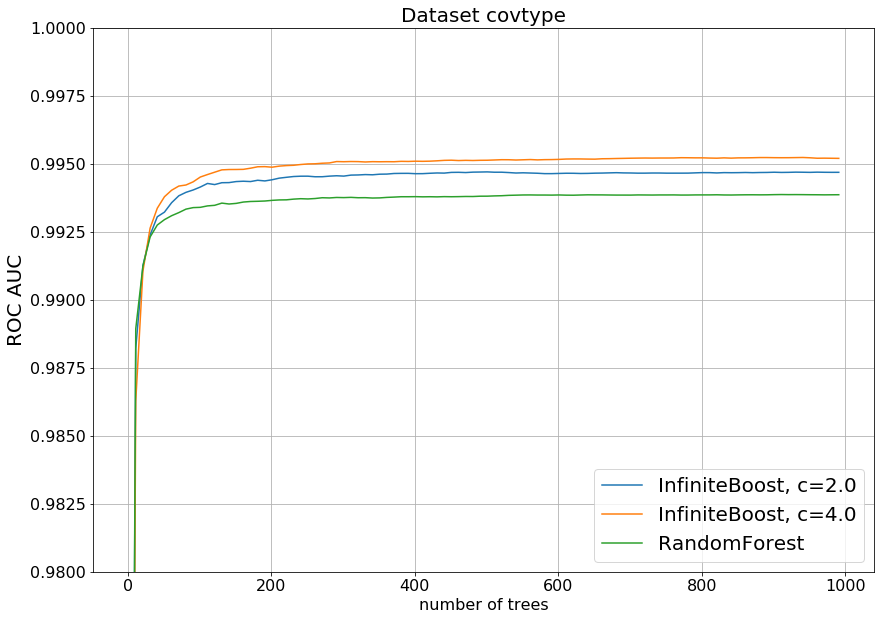

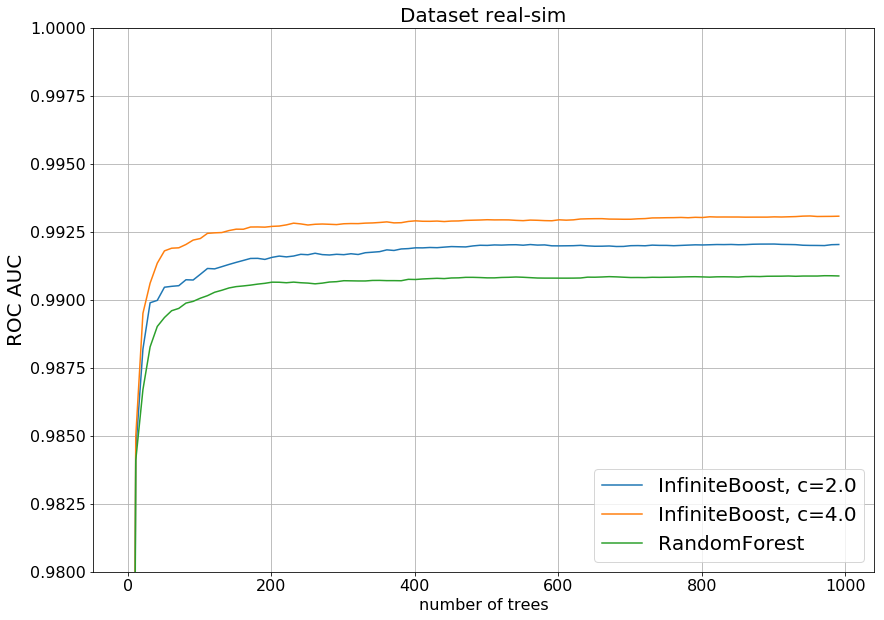

In [19]:
from itertools import groupby

plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16 
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True
    
for dataset_name, grouped_models in groupby(test_qualities.items(), lambda x: x[0][0]):
    plt.figure(figsize=[14, 10])
    for (dataset_name2, model_name), (stops, qualities) in grouped_models:
        plt.plot(stops, qualities, label=model_name)
        
    plt.grid()
    plt.xlabel('number of trees', fontsize=16)
    plt.ylabel('ROC AUC', fontsize=20)
    plt.title("Dataset {}".format(dataset_name), fontsize=20)

    plt.legend(loc='lower right', fontsize=20)
    plt.ylim(0.98, 1.00)

    plt.savefig('./plots/forest_longrun_{}.pdf'.format(dataset_name), bbox_inches='tight')
    plt.show()